Attempts to deconstruct the DelfinMesher class in order to understand how the mesh is split into subdomains

In [1]:
from cideMOD.mesh.base_mesher import SubdomainGenerator

In [2]:
def check_subdomains(subdomains, field_data):
        # DEBUG only - Check subdomains components
        # if MPI.size(MPI.comm_world) == 1:
        #     sd_array = self.subdomains.array().copy()
        #     assert len(set(sd_array)) == len(set(self.structure)), 'Some elements not inside a subdomain'
        #     for i, sd in enumerate(sd_array):
        #         if i == 0:
        #             assert sd == sd_array[i+1], 'A subdomain has only one element'
        #         elif i == len(sd_array)-1:
        #             assert sd == sd_array[i-1], 'A subdomain has only one element'
        #         else:
        #             assert sd in (sd_array[i+1], sd_array[i-1]), 'A subdomain has only one element'
        # Ensure electrode subdomains have higest values
        assert max([val for val in field_data.values() if isinstance(val,int)]) < 10, 'Unusualy high subdomain id'
        subdomains.array()[subdomains.array()==field_data['anode']] = 11
        subdomains.array()[subdomains.array()==field_data['cathode']] = 12
        field_data['anode'] = 11
        field_data['cathode'] = 12
        return subdomains, field_data

Load the cylinder mesh, after converting from .msh to .xdmf

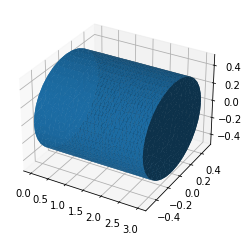

In [15]:
from dolfin import Mesh,plot, MeshTransformation,Point
#Cylinder
tx=Point(1.5,0,0)
tz=Point(0,0,-1.5)
mesh=Mesh("cylinder_3.xml")
rot=MeshTransformation
rot.rotate(mesh,90,1)
rot.translate(mesh, tx)
rot.translate(mesh,tz)
plot(mesh)

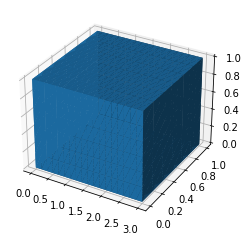

In [14]:
#Cube
from dolfin import BoxMesh, Point
n=3
Nx=6
Ny=6
Nz=6

p1 = Point(0,0,0)
p2 = Point(n,1,1)
mesh = BoxMesh(p1,p2, Nx*n, Ny or Nx, Nz or Nx)
plot(mesh)

Define some prereqs, same as in DolfinMesher

In [16]:
from dolfin import MeshFunction

dimension = mesh.geometric_dimension()
subdomain_generator = SubdomainGenerator()
n=3

field_data={}
field_data['anode'] = 1
field_data['separator'] = 2
field_data['cathode'] = 3
field_data['negativeCC'] = 4
field_data['positiveCC'] = 5
field_data['negativePlug'] = 6
field_data['positivePlug'] = 7
field_data['interfaces'] = {
'anode-separator': 1,
'cathode-separator': 2,
'anode-CC': 3,
'cathode-CC': 4,
}

# Mark boundaries
boundaries = MeshFunction("size_t", mesh, mesh.topology().dim() - 1, 0)
structure=['a','s','c']
if structure[-1] in ('c','pcc') or not 'c' in structure:
    negativetab = subdomain_generator.set_boundary(0)
    positivetab = subdomain_generator.set_boundary(n)
else:
    negativetab = subdomain_generator.set_boundary(n)
    positivetab = subdomain_generator.set_boundary(0)
negativetab.mark(boundaries, field_data['negativePlug'])
positivetab.mark(boundaries, field_data['positivePlug'])

Marking subdomains

In [17]:
n=len(structure)
tabs = subdomain_generator.set_boundaries(0, n)


Marking subdomains

In [36]:
from dolfin import XDMFFile
subdomains = MeshFunction("size_t", mesh, mesh.topology().dim(), 99)

anode_list = [index for index, element in enumerate(structure) if element == 'a']
cathode_list = [index for index, element in enumerate(structure) if element == 'c']
separator_list = [index for index, element in enumerate(structure) if element == 's']
positive_cc_list = [index for index, element in enumerate(structure) if element == 'pcc']
negative_cc_list = [index for index, element in enumerate(structure) if element == 'ncc']

negative_cc = subdomain_generator.set_domain(negative_cc_list)
anode = subdomain_generator.set_domain(anode_list)
separator = subdomain_generator.set_domain(separator_list)
cathode = subdomain_generator.set_domain(cathode_list)
positive_cc = subdomain_generator.set_domain(positive_cc_list)

electrodes = subdomain_generator.electrodes(structure)
electrolyte = subdomain_generator.electrolyte(structure)
solid_conductor = subdomain_generator.solid_conductor(structure)
current_colectors = subdomain_generator.current_collectors(structure)

negative_cc.mark(subdomains, field_data['negativeCC'])
anode.mark(subdomains,field_data['anode'])
separator.mark(subdomains,field_data['separator'])
cathode.mark(subdomains,field_data['cathode'])
positive_cc.mark(subdomains, field_data['positiveCC'])

subdomains = subdomains
subdomains,field_data=check_subdomains(subdomains,field_data)
print(positive_cc_list)

[]


Using the code above for a non-structured cylinder grid does not seem to be working. We therefore make one by hand

In [18]:
from dolfin import CompiledSubDomain, XDMFFile

electrodes = subdomain_generator.electrodes(structure)
electrolyte = subdomain_generator.electrolyte(structure)
solid_conductor = subdomain_generator.solid_conductor(structure)
current_colectors = subdomain_generator.current_collectors(structure)

subdomains = MeshFunction("size_t", mesh, mesh.topology().dim(),0)
# #Works by the bullshit-method
# tol=1e-10
# anode=CompiledSubDomain("x[0]>=-tol && x[0]<=1 || (x[1]<1+tol && x[1]>-1-tol && x[0]<1.5)",tol=tol)
# anode_b=CompiledSubDomain("on_boundary && near(x[0],1,tol)",tol=tol)
# cathode=CompiledSubDomain("x[0]>=2 && x[0]<3 || (x[1]<1+tol && x[1]>-1-tol && x[0]>1.5)",tol=tol)
# separator=CompiledSubDomain("x[0]>=1-0.001 && x[0]<=2+tol ",tol=tol)
#Using subdomains in cell mode, we get right answer by making the tolerance much larger
tol=1e-3
anode=CompiledSubDomain("x[0]>=-tol && x[0]<=1+tol",tol=tol)
separator=CompiledSubDomain("x[0]>=1-tol && x[0]<=2+tol",tol=tol)
cathode=CompiledSubDomain("x[0]>=2-tol && x[0]<=3+tol",tol=tol)
# #Alternative: use vertex mode
# subdomains = MeshFunction("size_t", mesh, 0,99) #First 0 => vertex mode
# tol=1e-10
# anode=CompiledSubDomain("x[0]>=-tol && x[0]<=1+tol",tol=tol)
# separator=CompiledSubDomain("x[0]>=1-tol && x[0]<=2+tol",tol=tol)
# cathode=CompiledSubDomain("x[0]>=2-tol && x[0]<=3+tol",tol=tol)
anode.mark(subdomains,field_data["anode"])
cathode.mark(subdomains,field_data["cathode"])
separator.mark(subdomains,field_data["separator"])
#subdomains,field_data=check_subdomains(subdomains,field_data)
XDMFFile("subdomains_lowtol.xdmf").write(subdomains)

We look at which parts of the mesh are defined as inside (this is used to set the domain)

In [25]:
from cideMOD.helpers.miscellaneous import inside_element_expression
ano=inside_element_expression(anode_list)
print(ano)
sep=inside_element_expression(separator_list)
print(sep)
cath=inside_element_expression(cathode_list)
print(cath)

NameError: name 'anode_list' is not defined

Marking the interfaces

In [37]:
interfaces = MeshFunction("size_t", mesh, mesh.topology().dim() -1, 0)

negativeCC_interfaces = set(negative_cc_list).union([i+1 for i in negative_cc_list])
anode_interfaces = set(anode_list).union([i+1 for i in anode_list])
separator_interfaces = set(separator_list).union([i+1 for i in separator_list])
cathode_interfaces = set(cathode_list).union([i+1 for i in cathode_list])
positiveCC_interfaces = set(positive_cc_list).union([i+1 for i in positive_cc_list])
anode_separator_interface_list = anode_interfaces.intersection(separator_interfaces)
anode_CC_interface_list = anode_interfaces.intersection(negativeCC_interfaces)
cathode_separator_interface_list = cathode_interfaces.intersection(separator_interfaces)
cathode_CC_interface_list = cathode_interfaces.intersection(positiveCC_interfaces)

anode_separator_interface = subdomain_generator.set_interface(anode_separator_interface_list)
cathode_separator_interface = subdomain_generator.set_interface(cathode_separator_interface_list)
anode_CC_interface = subdomain_generator.set_interface(anode_CC_interface_list)
cathode_CC_interface = subdomain_generator.set_interface(cathode_CC_interface_list)

anode_separator_interface.mark(interfaces,field_data['interfaces']['anode-separator'])
cathode_separator_interface.mark(interfaces,field_data['interfaces']['cathode-separator'])
anode_CC_interface.mark(interfaces,field_data['interfaces']['anode-CC'])
cathode_CC_interface.mark(interfaces,field_data['interfaces']['cathode-CC'])
print(anode_interfaces)

{0, 1}


Doing a self- made definition of the interfaces

In [38]:
interfaces=MeshFunction('size_t',mesh, 2,0)
anode_separator=CompiledSubDomain("(x[0]-1<tol && x[0]-1>0)|| (1-x[0]<tol && 1-x[0]>0)",tol=tol)
#(x[0]-2<tol && x[0]-2>0)|| (2-x[0]<tol && 2-x[0]>0)
cathode_separator=CompiledSubDomain("(x[0]-2<tol && x[0]-2>0)|| (2-x[0]<tol && 2-x[0]>0)",tol=tol)

anode_separator.mark(interfaces,20)
cathode_separator.mark(interfaces,60)

XDMFFile("interfaces_lowtol.xdmf").write(interfaces)
face_interface=interfaces.array()
b=mesh.coordinates()

Restrictions

In [16]:
from multiphenics import MeshRestriction
anode = MeshRestriction(mesh, anode)
separator = MeshRestriction(mesh, separator)
cathode = MeshRestriction(mesh, cathode)
#positiveCC = MeshRestriction(mesh, positive_cc)
#negativeCC = MeshRestriction(mesh, negative_cc)
field_restrictions = {
'anode':anode, 'separator':separator, 'cathode':cathode#, 'positiveCC':positiveCC, 'negativeCC':negativeCC
}
electrodes = MeshRestriction(mesh, electrodes)
electrolyte = MeshRestriction(mesh, electrolyte)
solid_conductor = MeshRestriction(mesh, solid_conductor)
current_colectors = MeshRestriction(mesh, current_colectors)
electrode_cc_interfaces = MeshRestriction(mesh, [anode_CC_interface, cathode_CC_interface])
positive_tab = MeshRestriction(mesh, positivetab)
tabs = MeshRestriction(mesh, tabs)

NameError: name 'positive_cc' is not defined

In [39]:
from dolfin import Measure

a_s_c_order = all([structure[i+1]=='s' for i, el in enumerate(structure) if el is 'a'])
def int_dir(default_dir="+"):
    assert default_dir in ("+","-")
    reversed_dir = "-" if default_dir == "+" else "-"
    return default_dir if a_s_c_order else reversed_dir
meta = {"quadrature_degree":2}
dx = Measure('dx', domain=mesh, subdomain_data=subdomains, metadata=meta)
dx_a = dx(field_data['anode'])
dx_s = dx(field_data['separator'])
dx_c = dx(field_data['cathode'])
dx_pcc = dx(field_data['positiveCC'])
dx_ncc = dx(field_data['negativeCC'])
ds = Measure('ds', domain=mesh, subdomain_data=boundaries, metadata=meta)
ds_a = ds(field_data['negativePlug'])
ds_c = ds(field_data['positivePlug'])
dS = Measure('dS', domain=mesh, subdomain_data=interfaces, metadata=meta)
dS_as = dS(field_data['interfaces']['anode-separator'], metadata={**meta, "direction": int_dir("+")})
dS_sa = dS(field_data['interfaces']['anode-separator'], metadata={**meta, "direction": int_dir("-")})
dS_sc = dS(field_data['interfaces']['cathode-separator'], metadata={**meta, "direction": int_dir("+")})
dS_cs = dS(field_data['interfaces']['cathode-separator'], metadata={**meta, "direction": int_dir("-")})
dS_cc_a = dS(field_data['interfaces']['anode-CC'], metadata={**meta, "direction": int_dir("+")})
dS_a_cc = dS(field_data['interfaces']['anode-CC'], metadata={**meta, "direction": int_dir("-")})
dS_cc_c = dS(field_data['interfaces']['cathode-CC'], metadata={**meta, "direction": int_dir("-")})
dS_c_cc = dS(field_data['interfaces']['cathode-CC'], metadata={**meta, "direction": int_dir("+")})
print(dS_sa)

dS(subdomain_id=10, domain=<Mesh #75>, metadata={'quadrature_degree': 2, 'direction': '-'}, subdomain_data=<dolfin.cpp.mesh.MeshFunctionSizet object at 0x7fb9948a7530>)


<>:3: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:3: SyntaxWarning: "is" with a literal. Did you mean "=="?
/tmp/ipykernel_33755/3086972088.py:3: SyntaxWarning: "is" with a literal. Did you mean "=="?
  a_s_c_order = all([structure[i+1]=='s' for i, el in enumerate(structure) if el is 'a'])


In [40]:
from dolfin import XDMFFile
XDMFFile("interfaces.xdmf").write(interfaces)
XDMFFile("subdomains.xdmf").write(subdomains)